In [2]:
import numpy as np
import tensorflow as tf
import t3f
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt

from gptt_embed.gpstruct import TTGPstruct
from gptt_embed import grid
from gptt_embed.covariance import SE_multidim
from gptt_embed.projectors import Identity
%load_ext autoreload
%autoreload 2

%matplotlib inline

## Data

In [3]:
x_tr = np.load('data/x_tr.npy')
x_te = np.load('data/x_te.npy')
y_tr = np.load('data/y_tr.npy')
y_te = np.load('data/y_te.npy')

In [4]:
x_tr[x_tr > 1] = 1
x_tr[x_tr < -1] = -1
x_te[x_te > 1] = 1
x_te[x_te < -1] = -1

In [5]:
D = x_tr.shape[-1]
max_len = x_tr.shape[1]
n_labels = 2
n_seq = x_tr.shape[0]

## GP

### Inducing Inputs

In [6]:
num = 10
inputs = grid.InputsGrid(D, left=-1., right=1., npoints=num)

### Kernel

In [7]:
projector = Identity(D)
cov = SE_multidim(n_labels, .7, .3, .1, projector)

### GP

In [8]:
mu_ranks = 5
gp = TTGPstruct(cov, inputs, mu_ranks)

## Graph creation

In [9]:
seq_lens = np.ones(shape=(n_seq,)) * max_len

In [10]:
x_tr = tf.constant(x_tr)
x_te = tf.constant(x_te)
y_tr = tf.constant(y_tr)
y_te = tf.constant(y_te)
seq_lens = tf.constant(seq_lens)

In [20]:
N = n_seq
lr = 1e-1
global_step = tf.Variable(0, trainable=False)

In [21]:
elbo_op, train_op = gp.fit(x_tr, y_tr, seq_lens, N, lr, global_step)

_latent_vars_distribution/x_flat (?, 2) = sum_len x 2
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 2
cov_for_squared_dists/cov (2, 100, 5, 5) = [2, 100, 5, 5]
_Knns/K_nn (2, 100, 5, 5) = 2 x 100 x 5 x 5
_sample_f/f_un (2, 100, 5) = 2 100 5
_sample_f/f_bin (4,) = 4


## Learning

In [22]:
sess = tf.Session()

In [23]:
gp.initialize(sess)
sess.run(tf.global_variables_initializer())

In [24]:
maxiter = 300
elbo_vals = []
for i in range(maxiter):
    _, elbo = sess.run([train_op, elbo_op])
    print(elbo)
    elbo_vals.append(elbo)

8.27846428534
6.58753277989
8.09473076596
6.77756289582
4.80683954546
6.824905037
7.95233029201
4.65919036889
9.44133510011
5.25769600379
3.56398467284
4.69237115586
7.43096104829
6.1746197009
4.19621094493
2.3038210289
13.4038950734
3.44952754194
10.9763123175
4.67408274314
2.74941316358
4.28733661198
2.58002850208
4.51204852769
7.09438927297
8.7086290502
1.7131241527
2.60872617966
7.3182328436
5.0911854982
7.10977747437
7.94159952562
5.9805034622
9.08986301825
6.04303833763
5.56983230912
7.15836706642
5.85679535074
4.68902589369
2.02592588457
5.51997734988
6.09862467554
3.33671185236
5.14314201919
7.83659040689
3.12824708882
4.65128898466
0.613285117875
5.93721464225
1.89777832996
2.57874876458
4.45384757896
7.63960813376
5.97712383036
5.48308630809
4.18546591636
2.39169361914
2.57912841229
1.96941362077
4.46781308776
5.48572908209
5.22242872661
4.41639773283
1.9208092835
4.316329693
7.43252002725
7.5365575512
2.29455746748
5.48526341306
5.06867042431
4.11560898861
4.20367830032
2.00

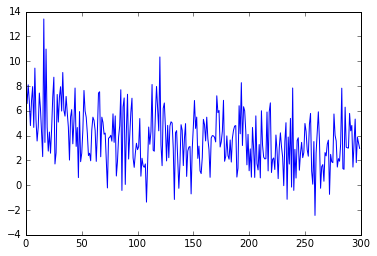

In [25]:
plt.plot(elbo_vals)

In [26]:
sess.run(gp.bin_mu)

array([ 0.80533293, -1.29563771, -1.43339272,  0.78891315])

In [27]:
sess.run(gp.bin_sigma_l)

array([[ 0.38979463,  0.11245341,  0.1532574 ,  0.29890226],
       [ 0.17390695,  0.57940048,  0.06817129,  0.22367735],
       [ 0.21892469,  0.040923  ,  0.5037274 ,  0.20607707],
       [ 0.33118395,  0.13344859,  0.16649125,  0.45372121]])

## Prediction

In [28]:
seq_lens_te = tf.constant(np.ones([x_te.shape[0]]) * max_len)

In [40]:
preds = gp.predict(x_te, seq_lens_te, sess)

_latent_vars_distribution/x_flat (?, 2) = sum_len x 2
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 2
cov_for_squared_dists/cov (2, 50, 5, 5) = [2, 50, 5, 5]
_Knns/K_nn (2, 50, 5, 5) = 2 x 50 x 5 x 5


In [46]:
np.sum(sess.run(y_te) == preds) / preds.size

0.68799999999999994

In [43]:
sess.run(y_te)

array([[0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [1, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0,

In [41]:
preds

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0,

In [48]:
sess.close()